In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

## Логистическая регрессия

Задачи регрессии относятся к прогнозированию непрерывного значения для выходной переменной на основе значений одной или нескольких входных переменных. 

В противоположность этому классификация занимается присваиванием дискретного значения (представляющего дискретный класс) выходной переменной на основе значений некоторых входных переменных. 

В обоих случаях задача состоит в том, чтобы получить модель, которая правильно формирует отображение соответствий между входными и выходными переменными. Чтобы добиться этого, необходимо иметь в своем распоряжении выборку с корректно определенными парами входных/выходных переменных. 

С точки зрения машинного обучения регрессии и классификации являются экземплярами алгоритмов обучения с учителем.

Модель логистической регрессии – это обобщение модели линейной регрессии для задач классификации, отсюда такое название. Такое обобщение производится посредством замены функции $f$  на логистическую функцию как функцию обратной связи:
$$ logistic(z) = \cfrac{1}{1+e^{-z}} $$

Для достижения нашей цели главным свойством этой логистической функции является то, что она фактически независима от значений ее аргумента $z$, поэтому результатом всегда будет число в интервале $[0,1]$. Таким образом, эту функцию можно рассматривать как удобный способ сжатия или упаковки значений, вычисляемых с помощью линейной модели, в диапазон значений, которые можно передать в распределение Бернулли. Эта логистическая функция также известна под названием сигмоидальная функция или просто сигма-функция, поскольку обладает характерной S-образной формой.

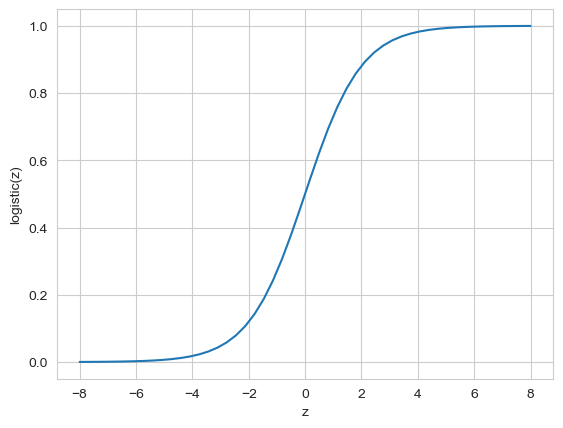

In [2]:
z = np.linspace(-8, 8) 
plt.plot(z, 1 / (1 + np.exp(-z))); 
plt.xlabel('z');
plt.ylabel('logistic(z)');

### Построение логистической модели

Превратим простую линейную модель в простую логистическую регрессию.

Начнем с варианта, в котором существуют только два класса (два типа экземпляров), например неспам/спам, безопасный/небезопасный, облачно/солнечно, здоровый/больной. 
Во-первых, необходимо закодировать эти классы, определив, скажем, что прогнозируемая переменная $y$ может принимать только два значения 0 и 1, то есть $y\in \{0,1\}$. Такую классификацию называют бинарной.<br>
После принятия этого предварительного условия задача становится похожей на пример с подбрасыванием монеты.

Помните, что мы  использовали распределение Бернулли как функцию правдоподобия. Отличие от задачи с подбрасыванием монеты состоит в том, что теперь $\theta$  генерируется не из бета-распределения, а определяется линейной моделью с логистической функцией, используемой как функция обратной связи. В итоге получаем (без известных априорных распределений):
$$ \theta = logistic(\alpha+x\beta)$$
$$ y=Bern(\theta) $$

Воспользуемся уже известным наи набором данных с цветами ириса.

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


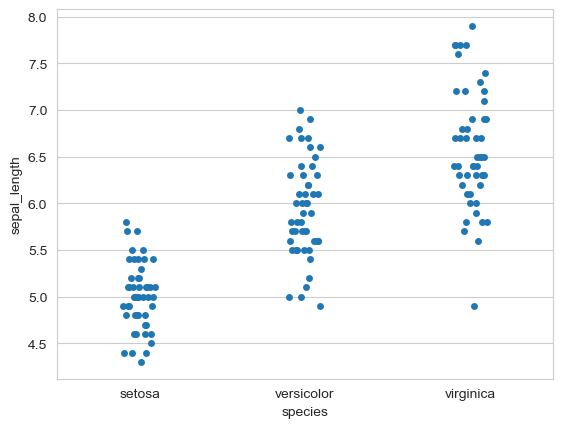

In [3]:
iris = sns.load_dataset("iris")
display(iris.head())
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True);

/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


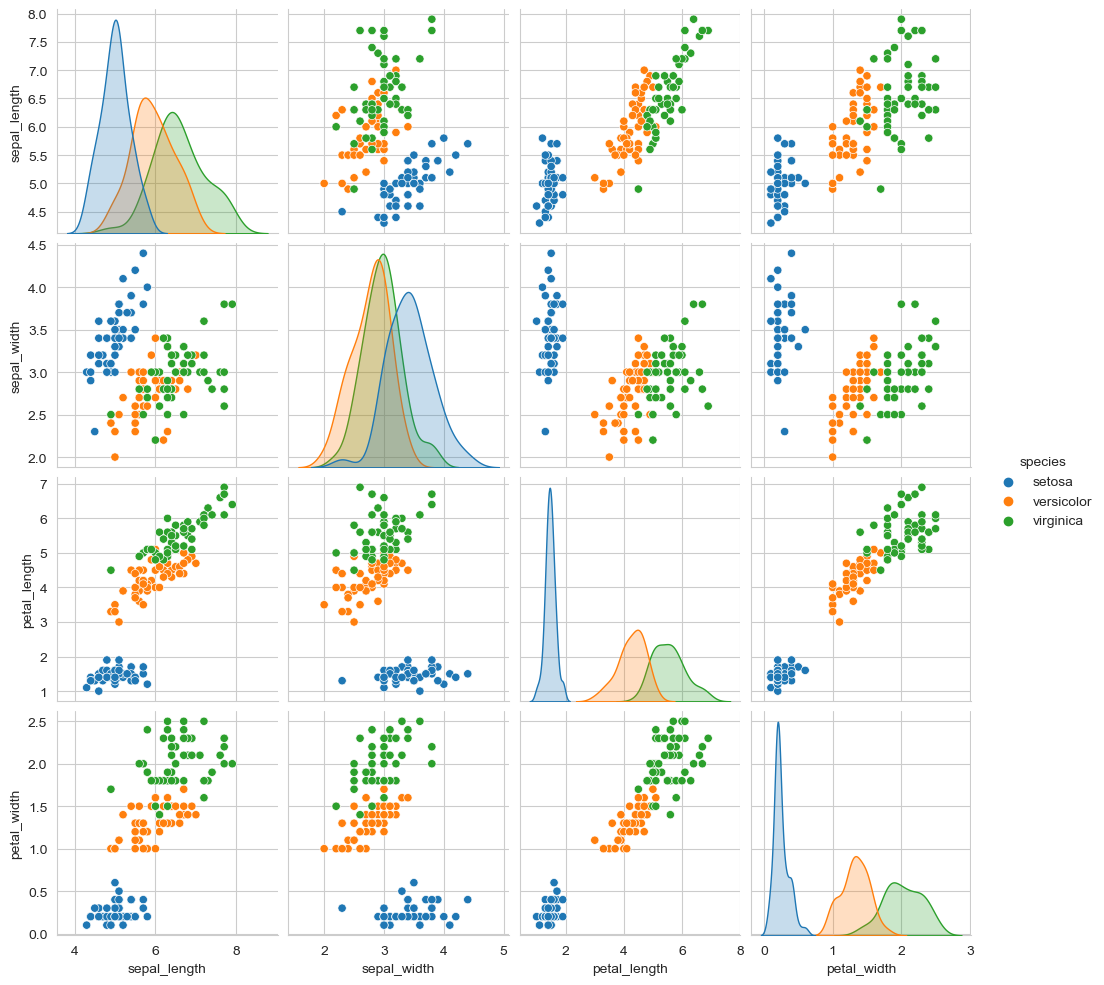

In [4]:
sns.pairplot(iris, hue='species', diag_kind='kde');

Пока мы говорим о модели бинарной классификации. Рассотрим только два типа цветков (setosa и versicolor) только одну независиммую переменную sepal_length (ширина чашелистника).

In [5]:
df = iris[iris.species.isin(["setosa", "versicolor"])]
display(df.head(3))
display(df.tail(3))

y_0 = pd.Categorical(df['species']).codes
column = 'sepal_length'

x_0 = df[column].values
x_c = x_0 - x_0.mean()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
97,6.2,2.9,4.3,1.3,versicolor
98,5.1,2.5,3.0,1.1,versicolor
99,5.7,2.8,4.1,1.3,versicolor


Как и при работе с другими линейными моделями, центрирование данных может помочь при формировании выборок. Сейчас исследуемые данные представлены в корректном формате, поэтому можно сразу перейти к заключительному этапу создания модели с использованием библиотеки PyMC.

Первая часть модели model_0 напоминает модель линейной регрессии. 

Также обратите внимание на две детерминированные переменные $\theta$ и $ bd $. Переменная $\theta$ – это выходные данные логистической функции, примененной к переменной $\mu$, а $ bd $ – граница решения, то есть значение, используемое для разделения классов.  

Более подробно граница решения рассмотрим несколько позже. Кроме того, заслуживает внимания тот факт, что вместо явной записи логистической функции мы воспользовались функцией pm.math.sigmoid это название логистической функции в библиотеки PyMC:

In [6]:
with pm.Model() as model_0:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=20) 
    β = pm.Normal('β', mu=0, sigma=10) 
    μ = α_tmp + pm.math.dot(x_c, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    #θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    
    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_0.mean())
    bd = pm.Deterministic('bd', -α/β)

    trace_0 = pm.sample(1000, chains = 4, cores = 4)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


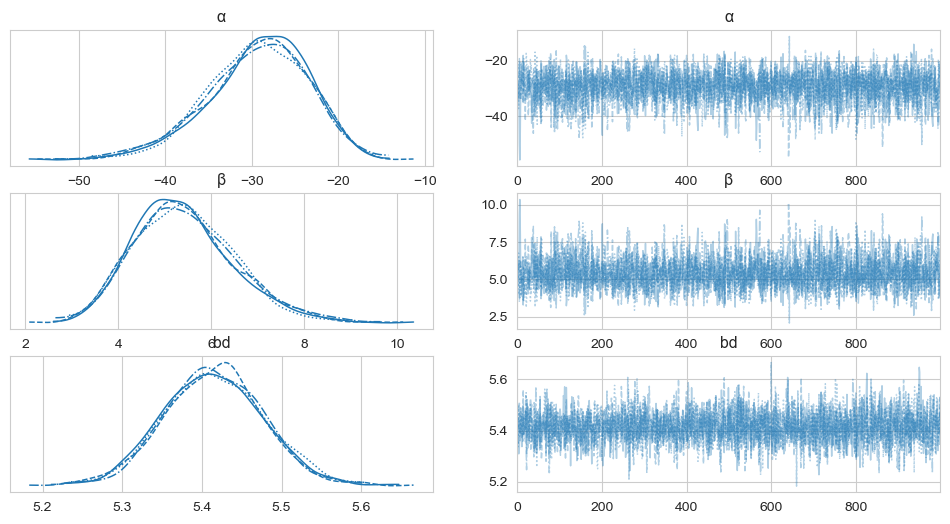

In [7]:
varnames = ['α', 'β', 'bd'];
az.plot_trace(trace_0, varnames);

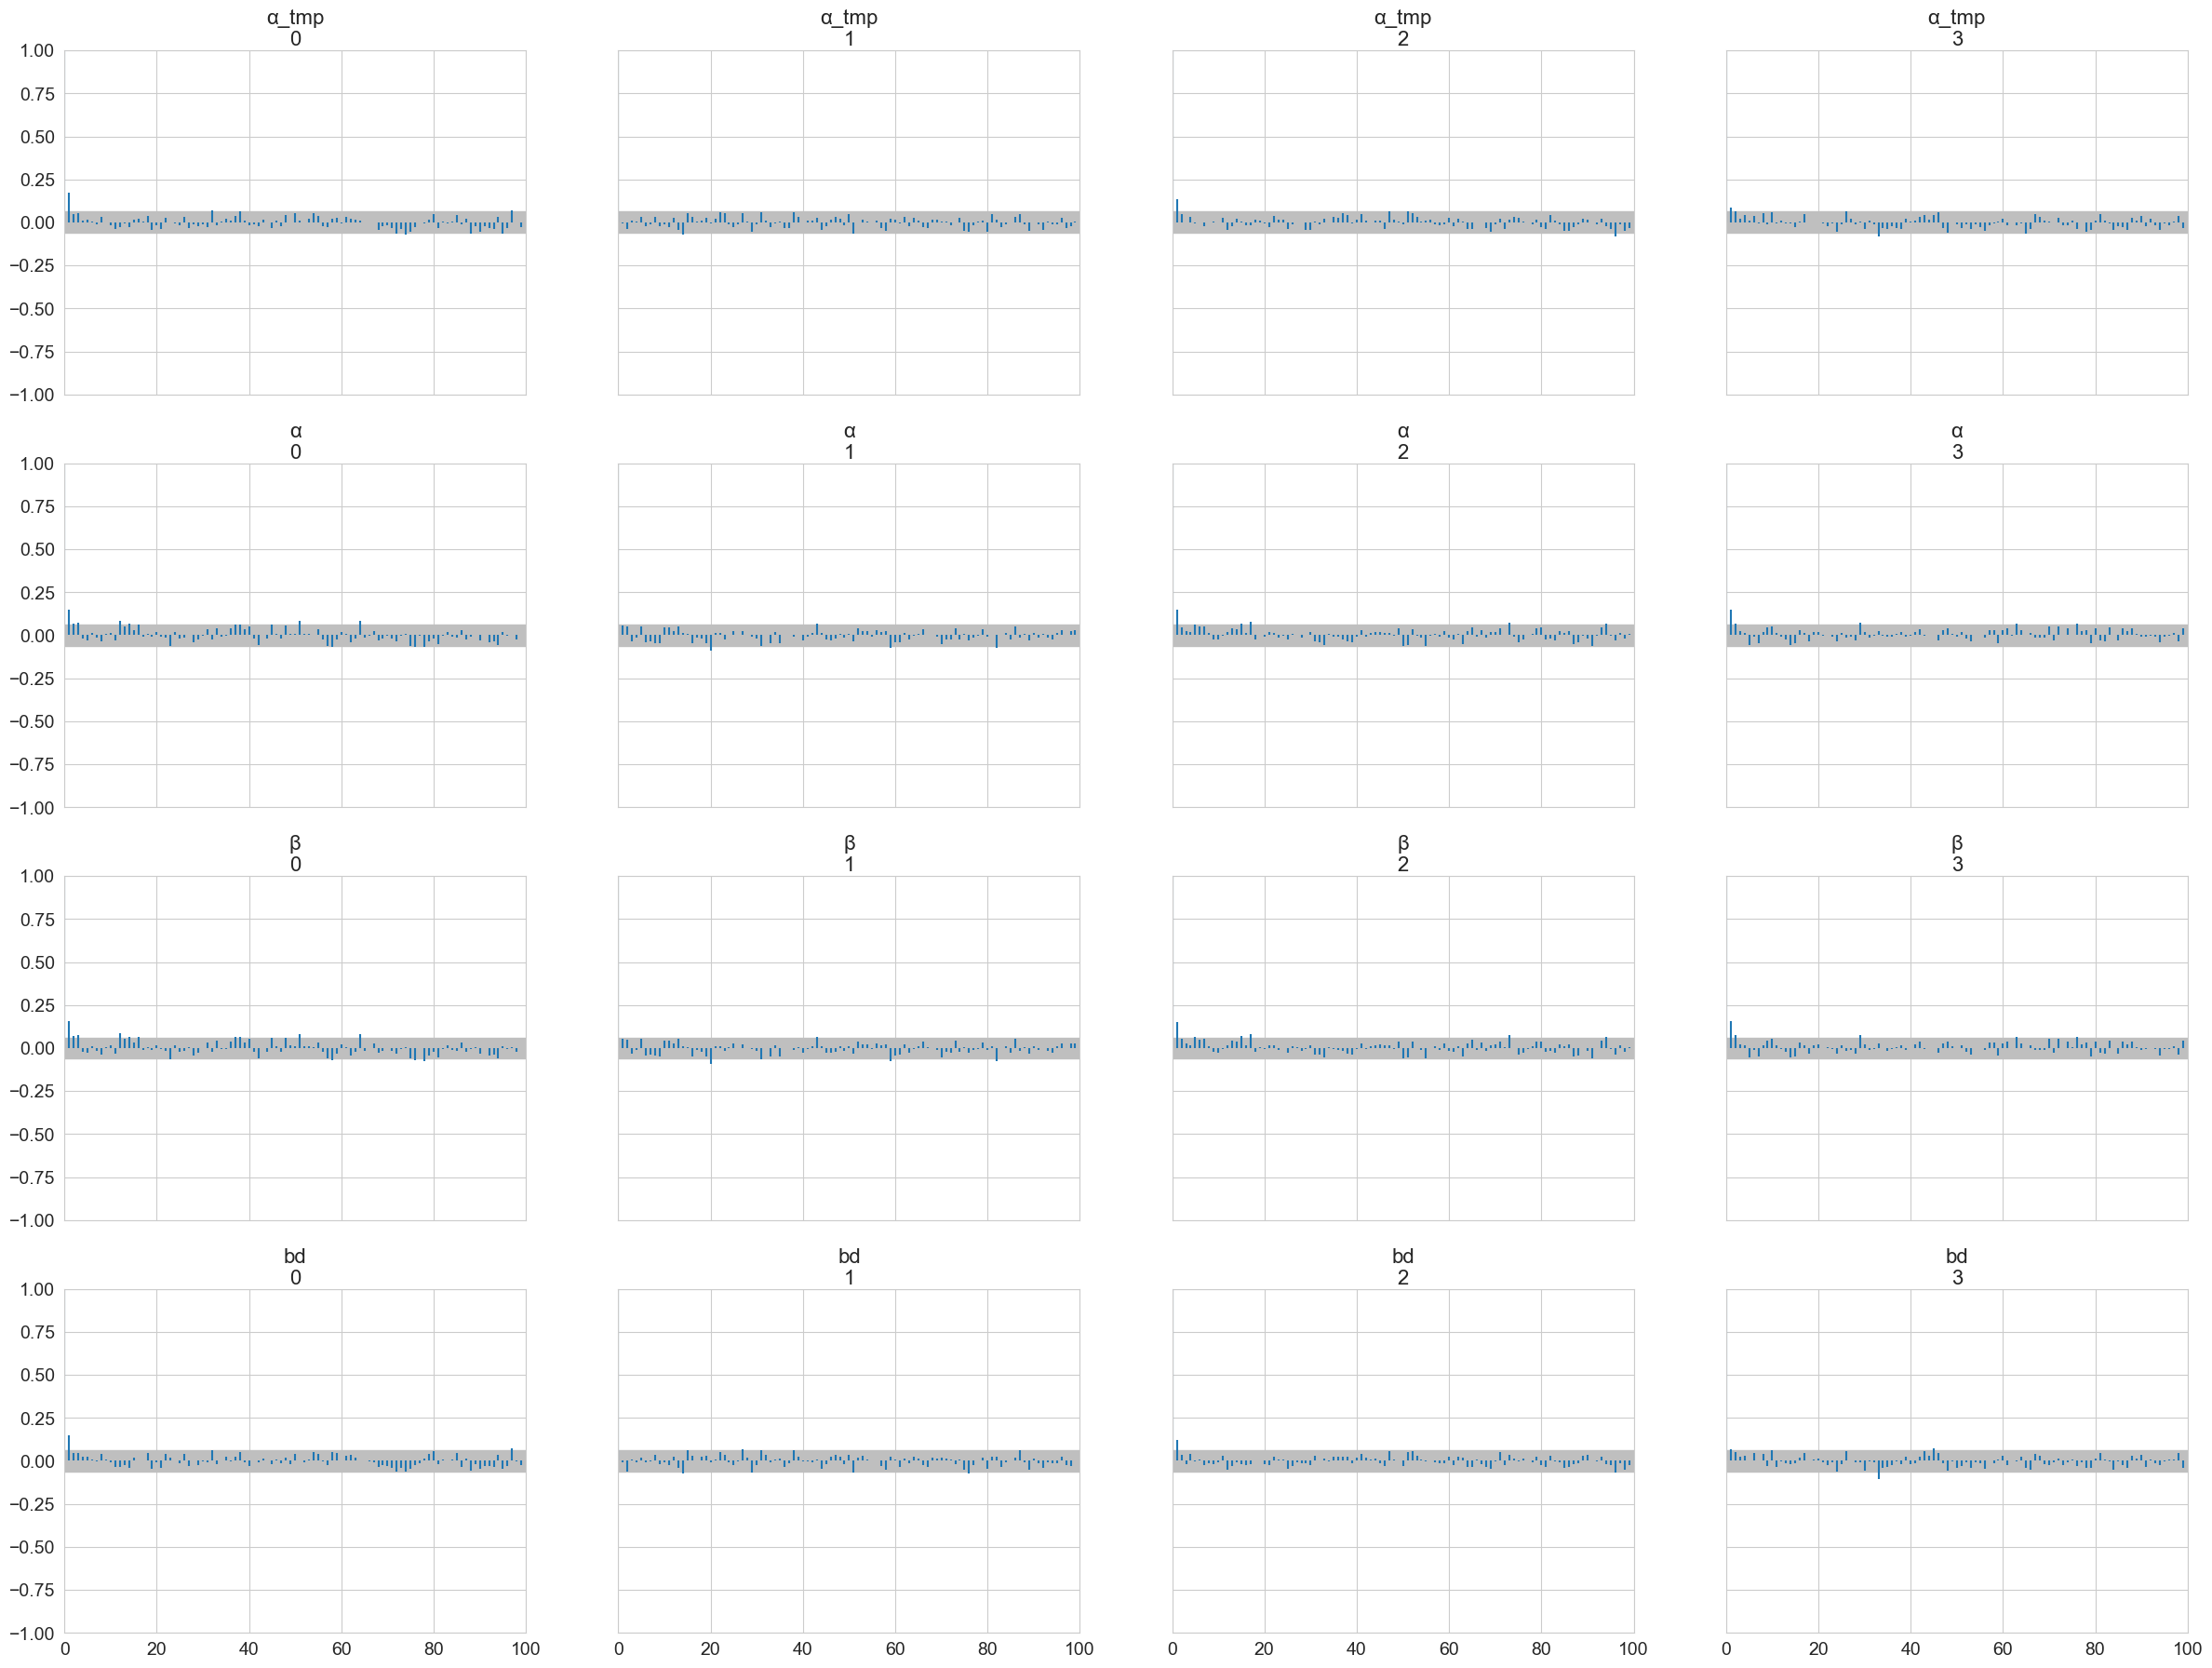

In [8]:
az.plot_autocorr(trace_0, ['α_tmp','α', 'β', 'bd']);

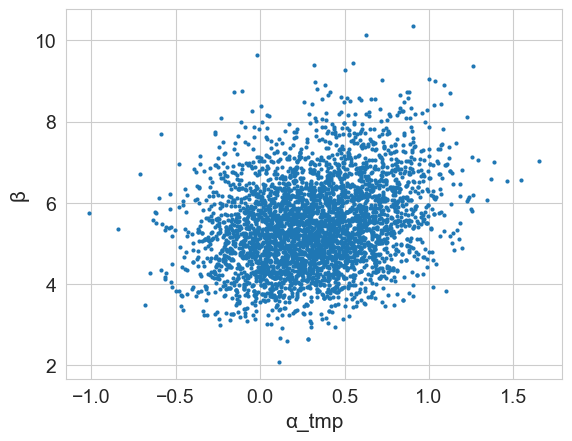

In [9]:
az.plot_pair(trace_0, var_names=['α_tmp', 'β']);

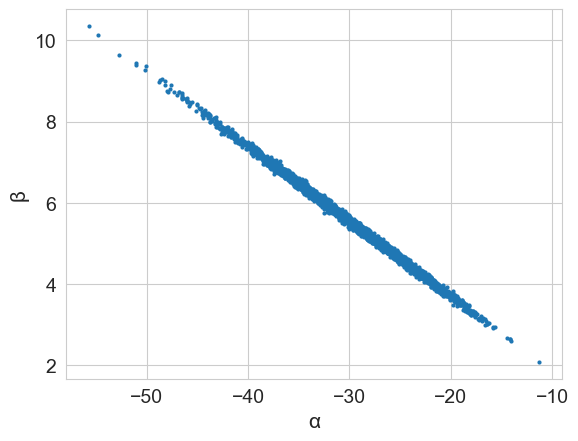

In [10]:
az.plot_pair(trace_0, var_names=['α', 'β']);

In [11]:
az.summary(trace_0, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-29.343,5.836,-39.886,-18.393,0.110,0.081,2908.0,2406.0,1.0
β,5.420,1.081,3.545,7.508,0.021,0.015,2867.0,2391.0,1.0
bd,5.415,0.062,5.301,5.532,0.001,0.001,3128.0,2474.0,1.0


/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'θ')

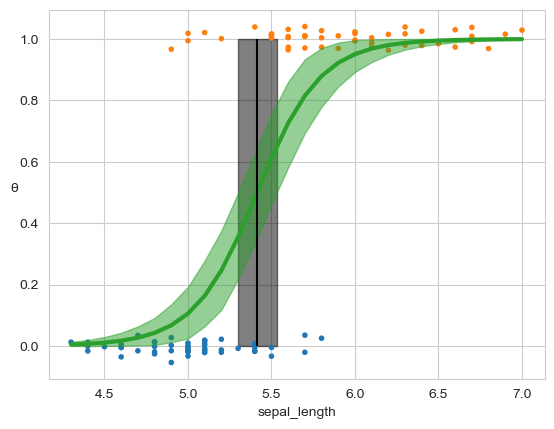

In [12]:
posterior_0 = trace_0.posterior.stack(samples=("chain", "draw"))

theta = posterior_0['θ'].mean("samples")
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='C2', lw=3)
plt.vlines(posterior_0['bd'].mean().item(), 0, 1, color='k')
bd_hpd = az.hdi(posterior_0['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_0, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_0, posterior_0['θ'].T, color='C2', smooth=False)

plt.xlabel(column);
plt.ylabel('θ', rotation=0)


In [13]:
posterior_0['θ'].values.T

array([[0.11822166, 0.03512824, 0.00978957, ..., 0.99429379, 0.11822166,
        0.87005576],
       [0.10913224, 0.03248023, 0.00911594, ..., 0.99343842, 0.10913224,
        0.85616176],
       [0.19378449, 0.07306251, 0.02519635, ..., 0.99104644, 0.19378449,
        0.87205975],
       ...,
       [0.11139361, 0.02932516, 0.00722823, ..., 0.99682638, 0.11139361,
        0.8995559 ],
       [0.27633334, 0.14891038, 0.07421866, ..., 0.96543545, 0.27633334,
        0.79877029],
       [0.09374517, 0.03192938, 0.01040699, ..., 0.98232843, 0.09374517,
        0.7614006 ]])

На схеме показаны данные о длине чашелистика sepal_length по двум видам ирисов (setosa = 0, versicolor = 1). Чтобы избежать чрезмерной плотности и перегруженности диаграммы, бинарные переменные результатов слегка смещены(разбросаны) по высоте, по оси y.

Синяя линяя – это среднее значение $\theta$. Эту линию можно интерпретировать как вероятность того, что цветок принадлежит к виду ирис разноцветный (versicolor), полагая, что нам известно значение длины чашелистиков. Полупрозрачная синяя полоса  – это интервал ПАР 94%.

Значения $x_i$ (в данном примере длины чашелистиков), расположенные слева от границы решения, относятся к классу 0 (setosa), а значения справа от границы решения – к классу 1 (versicolor).

Граница решения определяется как значение $x_i$, для которого $y = 0.5$. Это значение равно отношению $–\cfrac{\alpha}{\beta}$, так как:
* из определения $logistic(z) = \cfrac{1}{1+e^{-z}}$, а $z = \alpha+x\beta$;
* очевидно, что если $z=0$, то  $\cfrac{1}{1 + e^{-z}}=0.5$, следовательно $\alpha+x\beta = 0$
* тогда  $x = –\cfrac{\alpha}{\beta}$

Отметим следующие важные факты:
* вообще говоря, значение $\theta$ определяется как $p(y = 1|x)$. В этом смысле логистическая регрессия является истинной регрессией. Главный момент состоит в том, что мы регрессируем вероятность того, что некоторая точка данных принадлежит классу 1 с учетом линейной комбинации признаков;
* здесь моделируется среднее значение бинарной переменной, то есть целое число в интервале [0,1]. Затем вводится правило преобразования этой вероятности в назначение принадлежности одному из двух классов. В рассматриваемом примере если $p(y = 1) \ge 0.5$, то определяется принадлежность классу 1, в противном случае – принадлежность классу 0;
* значение 0.5 не является каким-то особенным, кроме того что это число, находящееся в середине интервала между 0 и 1. Конечно, можно отметить, что эта граница обоснована только в том случае, если ошибки равновероятны в обоих направлениях относительно середины интервала, другими словами, если нет никакой разницы между неправильной классификацией ириса щетинистого (setosa) как ириса разноцветного (versicolor) и ириса разноцветного как ириса щетинистого. Но это не всегда так, и издержки, связанные с неправильной классификацией, не обязательно являются симметричными.

In [14]:
def classify(X, threshold):
    """
    Моя классификационная функция
    """
    X = np.array(X)
    μ = posterior_0['α'].mean().values + posterior_0['β'].mean().values * X
    prob = 1 / (1 + np.exp(-μ)) # нельзя использовать pm.math.dot т.к. X не тензор 
    return prob, np.where(prob >= threshold,1,0)

classify([5, 5.5, 6], 0.5)

(array([0.09604981, 0.61495361, 0.96000843]), array([0, 1, 1]))

### Примечание

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-23.304,4.128,-31.522,-16.119,0.176,0.126,554.0,600.0,1.01
β,4.305,0.766,2.883,5.745,0.033,0.023,554.0,629.0,1.01
bd,5.414,0.072,5.279,5.552,0.001,0.001,3287.0,2778.0,1.00


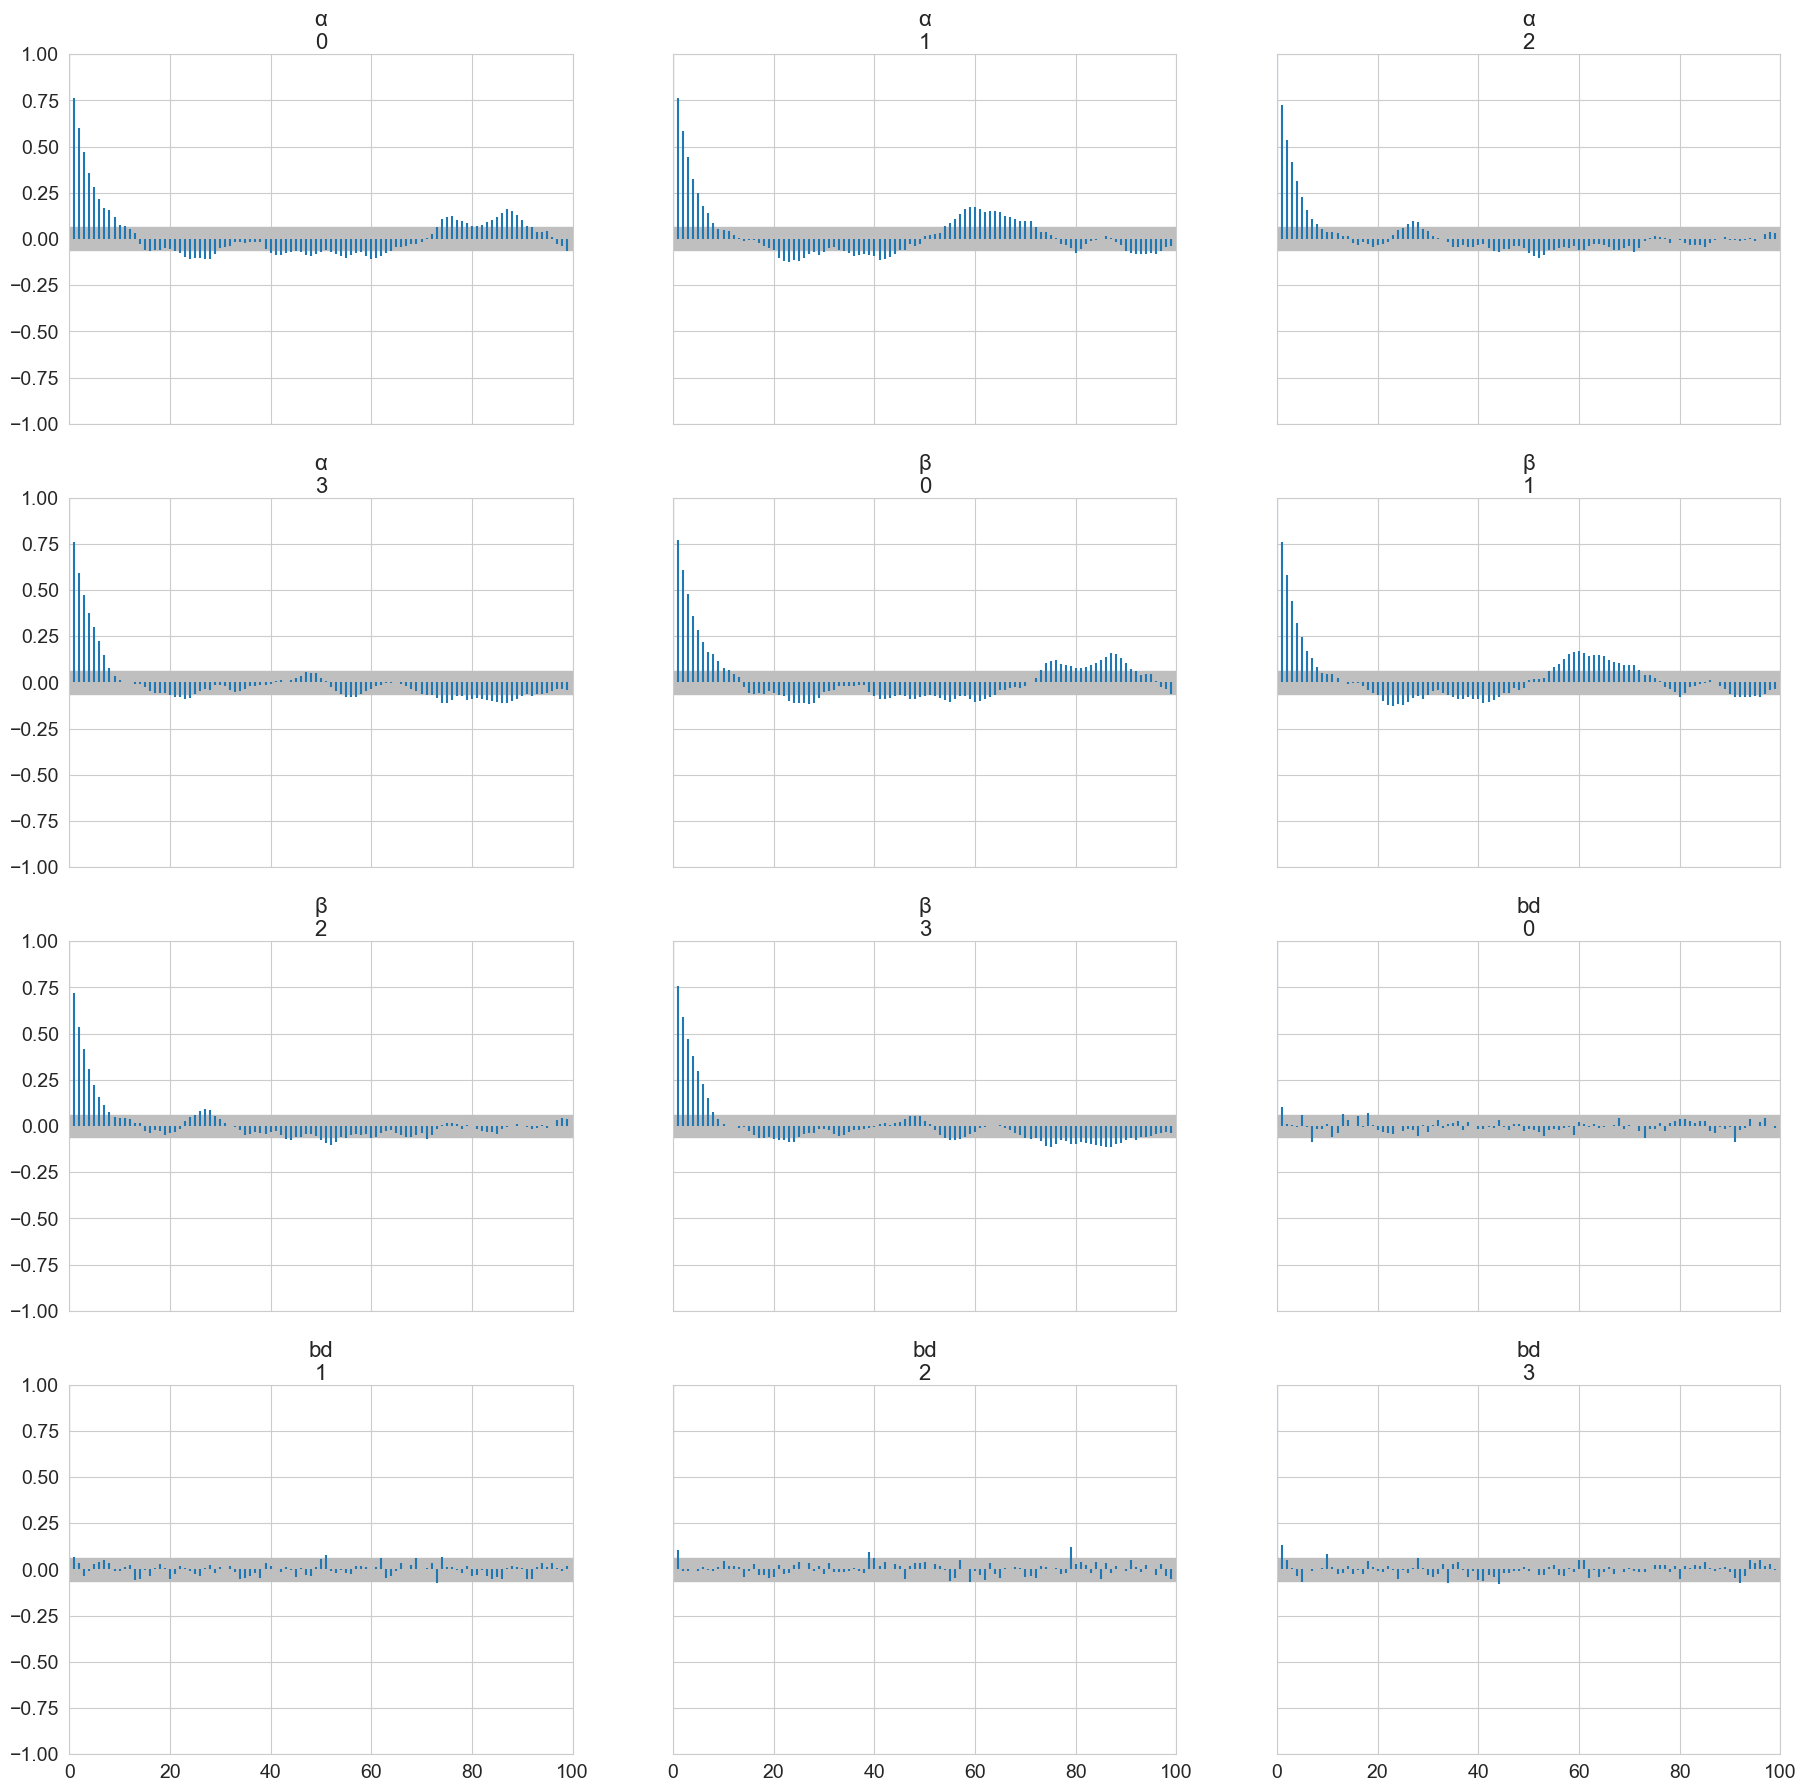

In [15]:
# еще раз почему плохо не сдвигать
with pm.Model() as model_1:
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=10) 
    μ = α + pm.math.dot(x_0, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    #θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β)
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    trace_1 = pm.sample(1000, chains = 4, cores = 4)
    
az.plot_autocorr(trace_1, ['α', 'β', 'bd']);
az.summary(trace_1, varnames)